# Crypto.com bid/ask perpetual futures data EDA

For details on how this data was obtained refer to
`docs/datapull/ck.cryptocom_data_pipeline.explanation.md`

## Dataset structure

- Order book data is stored as a set of compressed `.gz` files 
- The files contain order book snapshots 
- Example data from 20th October 2023:

```
sftp> pwd
Remote working directory: /exchange/book_l2_150_0010/2023/10/20/cdc/BTCUSD-PERP
sftp> ls
1697760000001.gz    1697760036853.gz    1697760093027.gz    1697760146098.gz    1697760195389.gz    1697760216857.gz    
1697760264748.gz    1697760316092.gz    1697760364434.gz    1697760396854.gz    1697760453532.gz    1697760512916.gz
```

- Name of the file refers to the start timestamp of the data interval stored in that file

- Example file /exchange/book_l2_150_0010/2023/10/20/cdc/BTCUSD-PERP/1697760000001.gz` (stored in gdrive [here](https://drive.google.com/file/d/1zKxQtraKtndUP8ZJgWeiQBdGSRspfb08/view?usp=drive_link))

## File structure

- Each line contains an order book update in JSON format:

```
> head -n 1 1697760000001 
{"S":"BTCUSD-PERP","s":"1","t":1697760000001,"p":1697760000006,"a":[[28725.5,6.0E-4],[28725.9,5.0E-4],[28726.2,0.035], ... ,"b":[[28722.9,0.035],[28722.4,0.04],... }
```

- "t" - transaction time
- "p" - message publish time

In [3]:
%load_ext autoreload
%autoreload 2

import logging
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im_v2.common.data.client.im_raw_data_client as imvcdcimrdc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
hdbg.init_logger(verbosity=logging.INFO)
log_level = logging.INFO

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  # Git
  branch_name='CmampTask8547_Short_EDA_on_crypto.com_bidask_historical_data'
  hash='92b22490b'
  # Last commits:
    * 92b22490b jsmerix  Add EDA notebook for crypto.com                                   (    2 days ago) Wed Jun 12 17:18:45 2024  (HEAD -> CmampTask8547_Short_EDA_on_crypto.com_bidask_historical_data, origin/CmampTask8547_Short_EDA_on_crypto.com_bidask_historical_data)
    * c0c50e2d1 jsmerix  Add link to notebook                                              (    2 days ago) Wed Jun 12 16:47:35 2024           
    * 7665e8163 Juraj Smeriga CmampTask8571_Document_crypto.com_data_access_interfaces (#8596)  (    2 days ago) Wed Jun 12 15:58:26 2024  (origin/master, origin/HEAD, master)
# Machine info
  system=Linux
  node name=70a82b70cb7f
  release=5.15.0-1058-aws
  version=#64~20.04.1-Ubuntu SMP Tue Apr 9 11:12:27 UTC 2024
  machine=x86_64
  processor=x86_64
  cpu count=8
  cpu freq=scpufreq(current=2499.998, min=0.0, max=0.0)
  memory=svmem(total=33280274432

## EDA

Load a couple of files to have ~15 minutes worth of data

In [33]:
# After gunzip 1697760000001.gz
files = [
    "./1697760000001",                                                                                                           
    "./1697760036853",                                                                                                           
    "./1697760093027",                                                                                                           
    "./1697760146098",                                                                                                           
    "./1697760195389",                                                                                                           
    "./1697760216857",                                                                                                           
    "./1697760264748",                                                                                                           
    "./1697760316092",                                                                                                           
    "./1697760364434",                                                                                                           
    "./1697760396854",                                                                                                           
    "./1697760453532",                                                                                                           
    "./1697760512916",                                                                                                           
    "./1697760552803",                                                                                                           
    "./1697760576885",                                                                                                           
    "./1697760636132",                                                                                                           
    "./1697760688324",                                                                                                           
    "./1697760739299",                                                                                                           
    "./1697760756904",                                                                                                           
    "./1697760824041",                                                                                                           
    "./1697760890235",                                                                                                           
    "./1697760936888",
    "./1697760996328"
]
dfs = []
for file in files:
    df_ = pd.read_json(file, lines=True)
    dfs.append(df_)

df = pd.concat(dfs, axis=0)

In [34]:
df.head()

,S,s,t,p,a,b
0,BTCUSD-PERP,1,1697760000001,1697760000006,"[[28725.5, 0.0006000000000000001], [28725.9, 0...","[[28722.9, 0.035], [28722.4, 0.04], [28722.2, ..."
1,BTCUSD-PERP,1,1697760000001,1697760000009,"[[28725.5, 0.0006000000000000001], [28725.9, 0...","[[28722.9, 0.035], [28722.4, 0.04], [28722.2, ..."
2,BTCUSD-PERP,1,1697760000026,1697760000026,"[[28725.5, 0.0006000000000000001], [28725.9, 0...","[[28722.9, 0.035], [28722.4, 0.04], [28722.2, ..."
3,BTCUSD-PERP,1,1697760000026,1697760000028,"[[28725.5, 0.0006000000000000001], [28725.9, 0...","[[28722.9, 0.035], [28722.4, 0.04], [28722.2, ..."
4,BTCUSD-PERP,1,1697760000046,1697760000047,"[[28725.5, 0.0006000000000000001], [28725.9, 0...","[[28722.9, 0.035], [28722.4, 0.04], [28722.2, ..."


In [35]:
df.shape

(92503, 6)

In [36]:
df.t.nunique()

46252

In [37]:
df.p.nunique()

92445

It can happen that publish time of the message is not unique for simplicity, we drop
those instances and set publish time as the index

In [38]:
df = df.drop_duplicates(subset=["p"])

In [39]:
df["p"] = pd.to_datetime(df['p'], unit="ms", utc=True)

In [40]:
df = df.set_index("p", drop=True)

## Top of the book plot

In [44]:
df["top_bid"] = df["b"].map(lambda x: x[0])
df["top_ask"] = df["a"].map(lambda x: x[0])

In [45]:
df["top_bid_price"] = df["top_bid"].map(lambda x: x[0])
df["top_ask_price"] = df["top_ask"].map(lambda x: x[0])

<Axes: xlabel='p'>

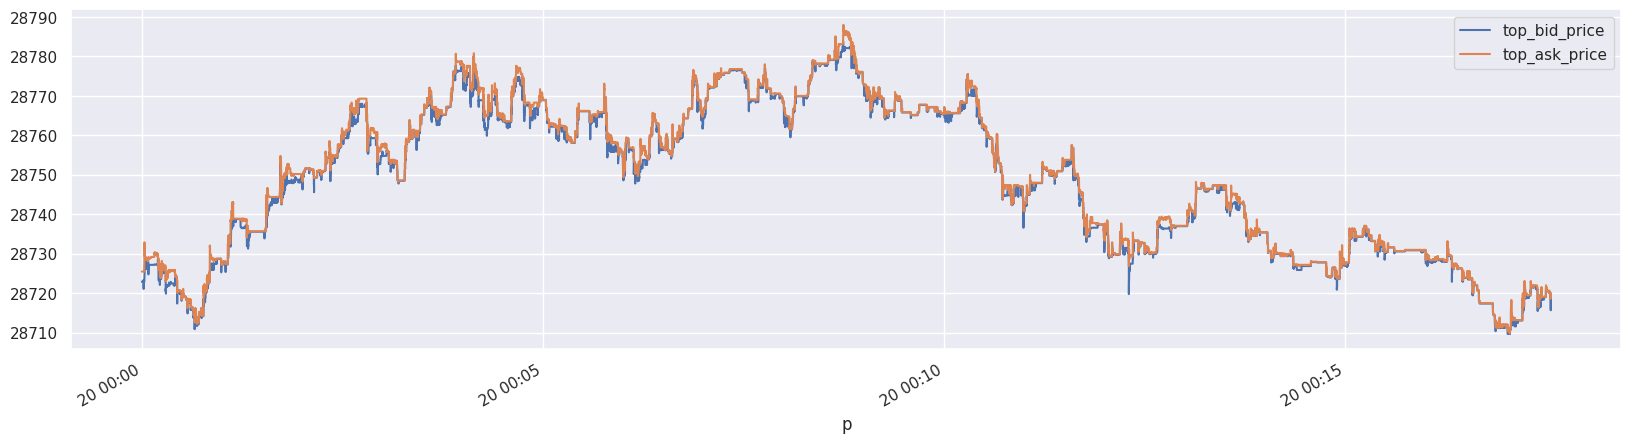

In [46]:
df[["top_bid_price", "top_ask_price"]].plot()

### Include OHLCV data in the plot

In [70]:
signature = "periodic_daily.airflow.downloaded_1min.parquet.ohlcv.futures.v7_4.ccxt.cryptocom.v1_0_0"
reader = imvcdcimrdc.RawDataReader(signature, stage="preprod")
# We will be adjusting 
start_timestamp = df.index.min() - pd.Timedelta(minutes=2)
end_timestamp = df.index.max()
ohlcv_data = reader.read_data(start_timestamp, end_timestamp, currency_pairs=["BTC_USD"])
_LOG.log(log_level, hpandas.df_to_str(ohlcv_data, log_level=log_level))

INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3


,timestamp,open,high,low,close,volume,exchange_id,knowledge_timestamp,currency_pair,year,month
2023-10-19 23:59:00+00:00,1697759940000,28722.1,28729.0,28720.3,28722.9,4.052,cryptocom,2024-01-20 19:21:35.381365+00:00,BTC_USD,2023,10
2023-10-20 00:00:00+00:00,1697760000000,28722.9,28729.2,28712.4,28727.5,5.1436,cryptocom,2024-01-20 19:21:35.381365+00:00,BTC_USD,2023,10
2023-10-20 00:01:00+00:00,1697760060000,28728.0,28751.9,28727.4,28749.6,7.029,cryptocom,2024-01-20 19:21:35.381365+00:00,BTC_USD,2023,10
,...,...,...,...,...,...,...,...,...,...,...
2023-10-20 00:15:00+00:00,1697760900000,28727.8,28737.0,28727.8,28731.6,3.5302,cryptocom,2024-01-20 19:21:35.381365+00:00,BTC_USD,2023,10
2023-10-20 00:16:00+00:00,1697760960000,28730.9,28731.0,28711.3,28712.7,3.706,cryptocom,2024-01-20 19:21:35.381365+00:00,BTC_USD,2023,10
2023-10-20 00:17:00+00:00,1697761020000,28712.0,28729.7,28711.0,28727.3,6.0442,cryptocom,2024-01-20 19:21:35.381365+00:00,BTC_USD,2023,10


INFO  None


In [71]:
df.head()

,S,s,t,a,b,top_bid,top_ask,top_bid_price,top_ask_price
p,,,,,,,,,
2023-10-20 00:00:00.006000+00:00,BTCUSD-PERP,1,1697760000001,"[[28725.5, 0.0006000000000000001], [28725.9, 0...","[[28722.9, 0.035], [28722.4, 0.04], [28722.2, ...","[28722.9, 0.035]","[28725.5, 0.0006000000000000001]",28722.9,28725.5
2023-10-20 00:00:00.009000+00:00,BTCUSD-PERP,1,1697760000001,"[[28725.5, 0.0006000000000000001], [28725.9, 0...","[[28722.9, 0.035], [28722.4, 0.04], [28722.2, ...","[28722.9, 0.035]","[28725.5, 0.0006000000000000001]",28722.9,28725.5
2023-10-20 00:00:00.026000+00:00,BTCUSD-PERP,1,1697760000026,"[[28725.5, 0.0006000000000000001], [28725.9, 0...","[[28722.9, 0.035], [28722.4, 0.04], [28722.2, ...","[28722.9, 0.035]","[28725.5, 0.0006000000000000001]",28722.9,28725.5
2023-10-20 00:00:00.028000+00:00,BTCUSD-PERP,1,1697760000026,"[[28725.5, 0.0006000000000000001], [28725.9, 0...","[[28722.9, 0.035], [28722.4, 0.04], [28722.2, ...","[28722.9, 0.035]","[28725.5, 0.0006000000000000001]",28722.9,28725.5
2023-10-20 00:00:00.047000+00:00,BTCUSD-PERP,1,1697760000046,"[[28725.5, 0.0006000000000000001], [28725.9, 0...","[[28722.9, 0.035], [28722.4, 0.04], [28722.2, ...","[28722.9, 0.035]","[28725.5, 0.0006000000000000001]",28722.9,28725.5


Add 1 minute to the index because crypto.com uses `b` to annotate interval `(a, b]`

In [72]:
ohlcv_data.index = ohlcv_data.index + pd.Timedelta(minutes=1)

In [73]:
ohlcv_data.head()

,timestamp,open,high,low,close,volume,exchange_id,knowledge_timestamp,currency_pair,year,month
timestamp,,,,,,,,,,,
2023-10-20 00:00:00+00:00,1697759940000,28722.1,28729.0,28720.3,28722.9,4.0520,cryptocom,2024-01-20 19:21:35.381365+00:00,BTC_USD,2023,10
2023-10-20 00:01:00+00:00,1697760000000,28722.9,28729.2,28712.4,28727.5,5.1436,cryptocom,2024-01-20 19:21:35.381365+00:00,BTC_USD,2023,10
2023-10-20 00:02:00+00:00,1697760060000,28728.0,28751.9,28727.4,28749.6,7.0290,cryptocom,2024-01-20 19:21:35.381365+00:00,BTC_USD,2023,10
2023-10-20 00:03:00+00:00,1697760120000,28749.6,28769.3,28748.3,28753.8,6.0544,cryptocom,2024-01-20 19:21:35.381365+00:00,BTC_USD,2023,10
2023-10-20 00:04:00+00:00,1697760180000,28755.8,28776.7,28748.6,28776.7,6.9660,cryptocom,2024-01-20 19:21:35.381365+00:00,BTC_USD,2023,10


In [74]:
ohlcv_data = ohlcv_data[["high", "low"]]

<Axes: >

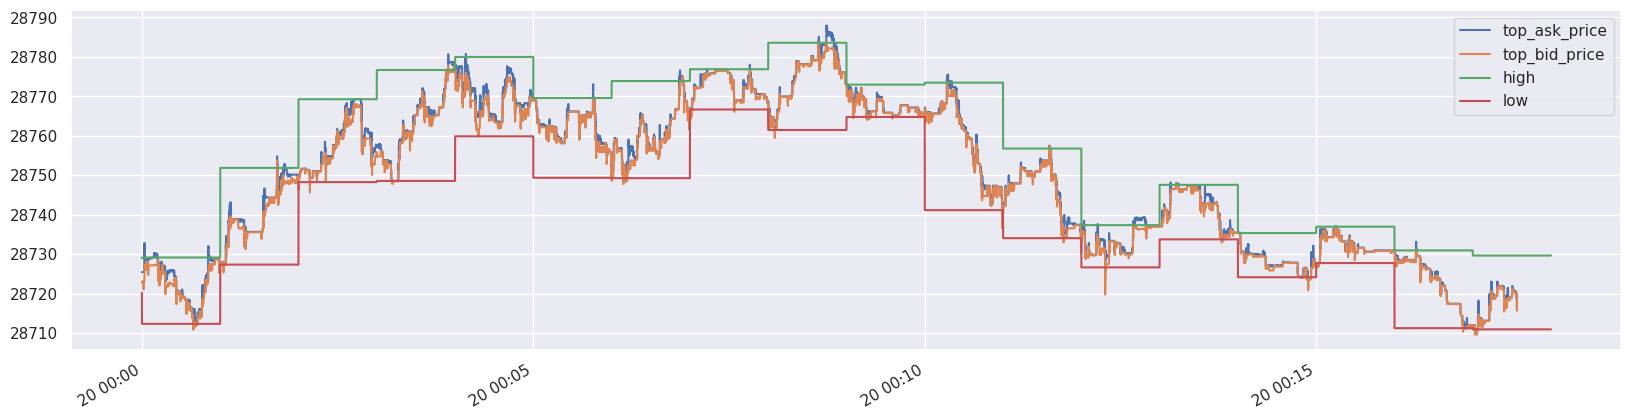

In [75]:
ohlcv_orderbook = pd.concat([df, ohlcv_data]).sort_index().bfill()
ohlcv_orderbook[["top_ask_price", "top_bid_price", "high", "low"]].plot()

There are mild misalignments - we should investigate longer time interval but these might be possible/normal.